## **1. Setting**

### **Install & Import**

In [1]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

import matplotlib as mpl
import matplotlib.pyplot as plt

plt.rc('font', family='NanumBarunGothic')

# 한글 출력 코드 : 실행 - 런타임 재실행하고 - 한번 더 실행 눌러주기

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 29 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

In [2]:
!pip install tslearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 3.7 MB/s eta 0:00:00


In [3]:
import random
import pandas as pd
import numpy as np
import os
import seaborn as sns

from tqdm import tqdm
from tslearn.clustering import TimeSeriesKMeans, silhouette_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from xgboost import XGBRegressor

import warnings
warnings.filterwarnings(action='ignore')

### **Set Directory**

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
%cd /content/drive/Othercomputers/예전 노트북/2023학년도 1학기/전력공모전

/content/drive/Othercomputers/예전 노트북/2023학년도 1학기/전력공모전


### **Fixed Random-Seed**

In [6]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(42) # Seed 고정

### **Load Data**

In [189]:
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')
info = pd.read_csv('./data/building_info.csv')

## **2. Pre-Processing**

### **Building_info**

In [190]:
# 변수명 정리
info.columns = ['build_num', 'build_type', 'total_area', 'cool_area', 'solar_capacity', 'ESS_capacity', 'PCS_capacity']

In [191]:
# 결측값 0으로 채우기
info = info.replace('-', 0)

In [192]:
# 데이터타입 변경
info['solar_capacity'] = info['solar_capacity'].astype(float)
info['ESS_capacity'] = info['ESS_capacity'].astype(float)
info['PCS_capacity'] = info['PCS_capacity'].astype(float)

In [193]:
# 냉방면적비율 변수 추가
info['cool_ratio'] = info['cool_area']/info['total_area']*100

In [194]:
# 건물유형 범주형 변수 처리
info_dummy = pd.get_dummies(info, columns=['build_type'])

### **Train**

In [195]:
# 변수명 정리
train.columns = ['num_date_time', 'build_num', 'date_time', 'temp', 'rain', 'wind', 'humid', 'sunshine', 'insolation', 'power_consum']

- 결측치 확인 및 처리

In [196]:
train.isna().sum()

,0
num_date_time,0
build_num,0
date_time,0
temp,0
rain,160069
wind,19
humid,9
sunshine,75182
insolation,87913
power_consum,0


In [197]:
# 강수량 0으로
train['rain'] = train['rain'].fillna(0)

In [198]:
# 풍속, 습도 선형보간
train['wind'] = train['wind'].interpolate(method='linear')
train['humid'] = train['humid'].interpolate(method='linear')

In [199]:
# 시계열 특성을 학습에 반영하기 위해 일시를 월, 일, 시간으로 나누기
train['date_time'] = pd.to_datetime(train['date_time'])
train["month"] = train["date_time"].dt.month
train["day"] = train["date_time"].dt.day
train["time"] = train["date_time"].dt.hour
train['weekday'] = train["date_time"].dt.weekday

In [200]:
# 시간의 순환적 특성 반영
train['sin_time'] = np.sin(2 * np.pi * train['time']/24.0)
train['cos_time'] = np.cos(2 * np.pi * train['time']/24.0)

In [201]:
# 주말 변수 추가
train['weekend'] = train.apply(lambda x : 0 if x['weekday']<5 else 1, axis = 1)

In [202]:
# 체감온도 변수 추가
def feel_temp(data):
    ta = data['temp'].values
    # 상대습도 : humid
    rh = data['humid'].values
    # 습구온도 (stull의 추정식)
    tw = ta * np.arctan(0.151977 * np.sqrt(rh+8.313659)) + np.arctan(ta+rh) - np.arctan(rh-1.67633) + 0.00391838 * rh**(3/2) * np.arctan(0.023101*rh) - 4.686035
    feel_temp = -0.2442 + 0.55399 * tw + 0.45535 * ta -0.0022 * tw**2 + 0.00278 * tw * ta + 3.0
    return feel_temp

train['feel_temp'] = feel_temp(train)

In [203]:
# 폭염 변수 추가
train['heat'] = train.apply(lambda x : 0 if x['feel_temp']<33 else 1, axis = 1)

In [204]:
# 호우 변수 추가
train['hrain'] = train.apply(lambda x : 0 if x['rain']<30 else 1, axis = 1)

In [205]:
# 낮 변수 추가
train['day_time'] = train.apply(lambda x : 0 if (6 <= x['time']) & (x['time'] < 18) else 1, axis = 1)

In [206]:
# 건물별 시간대별 발전량 평균
power_time_mean = pd.pivot_table(train, values = 'power_consum', index = ['build_num', 'time'], aggfunc = np.mean).reset_index()
tqdm.pandas()
train['time_mean'] = train.progress_apply(lambda x : power_time_mean.loc[(power_time_mean.build_num == x['build_num']) & (power_time_mean.time == x['time']) ,'power_consum'].values[0], axis = 1)

100%|██████████| 204000/204000 [01:51<00:00, 1834.53it/s]


In [207]:
# 건물별 시간대별 발전량 표준편차
power_time_std = pd.pivot_table(train, values = 'power_consum', index = ['build_num', 'time'], aggfunc = np.std).reset_index()
tqdm.pandas()
train['time_std'] = train.progress_apply(lambda x : power_time_std.loc[(power_time_mean.build_num == x['build_num']) & (power_time_mean.time == x['time']) ,'power_consum'].values[0], axis = 1)

100%|██████████| 204000/204000 [01:48<00:00, 1881.29it/s]


In [208]:
train = train.drop(columns=['sunshine', 'insolation'])

### **Test**

In [209]:
# 변수명 정리
test.columns = ['num_date_time', 'build_num', 'date_time', 'temp', 'rain', 'wind', 'humid']

In [210]:
# 시계열 특성을 학습에 반영하기 위해 일시를 월, 일, 시간으로 나누기
test['date_time'] = pd.to_datetime(test['date_time'])
test["month"] = test["date_time"].dt.month
test["day"] = test["date_time"].dt.day
test["time"] = test["date_time"].dt.hour
test["weekday"] = test["date_time"].dt.weekday

In [211]:
# 시간의 순환적 특성 반영
test['sin_time'] = np.sin(2 * np.pi * test['time']/24.0)
test['cos_time'] = np.cos(2 * np.pi * test['time']/24.0)

In [212]:
# 주말 변수 추가
test['weekend'] = test.apply(lambda x : 0 if x['weekday']<5 else 1, axis = 1)

In [213]:
# 체감온도 변수 추가
test['feel_temp'] = feel_temp(test)

In [214]:
# 폭염 변수 추가
test['heat'] = test.apply(lambda x : 0 if x['feel_temp']<33 else 1, axis = 1)

In [215]:
# 호우 변수 추가
test['hrain'] = test.apply(lambda x : 0 if x['rain']<30 else 1, axis = 1)

In [216]:
# 낮 변수 추가
test['day_time'] = test.apply(lambda x : 0 if (6 <= x['time']) & (x['time'] < 18) else 1, axis = 1)

In [217]:
# 건물별 시간대별 발전량 평균
tqdm.pandas()
test['time_mean'] = test.progress_apply(lambda x : power_time_mean.loc[(power_time_mean.build_num == x['build_num']) & (power_time_mean.time == x['time']) ,'power_consum'].values[0], axis = 1)

100%|██████████| 16800/16800 [00:09<00:00, 1798.41it/s]


In [218]:
# 건물별 시간대별 발전량 표준편차
tqdm.pandas()
test['time_std'] = test.progress_apply(lambda x : power_time_std.loc[(power_time_mean.build_num == x['build_num']) & (power_time_mean.time == x['time']) ,'power_consum'].values[0], axis = 1)

100%|██████████| 16800/16800 [00:09<00:00, 1798.13it/s]


### **Time Series Clustering**

In [219]:
# 시계열 군집화용 데이터 생성하는 함수
def cluster_df(scaler=MinMaxScaler()): # scaler=[False, 'MinMaxScaler()', 'StandardScaler()']
    train_ = train.copy()
    train_ts = train_.pivot_table(values = 'power_consum', index = train_.build_num, columns = 'date_time', aggfunc = 'first')

    if scaler:
        train_ts_T = scaler.fit_transform(train_ts.T)
        train_ts = pd.DataFrame(train_ts_T.T, index=train_ts.index, columns=train_ts.columns)

    return train_ts

In [220]:
train_ts = cluster_df()

In [221]:
train_ts

date_time,2022-06-01 00:00:00,2022-06-01 01:00:00,2022-06-01 02:00:00,2022-06-01 03:00:00,2022-06-01 04:00:00,2022-06-01 05:00:00,2022-06-01 06:00:00,2022-06-01 07:00:00,2022-06-01 08:00:00,2022-06-01 09:00:00,...,2022-08-24 14:00:00,2022-08-24 15:00:00,2022-08-24 16:00:00,2022-08-24 17:00:00,2022-08-24 18:00:00,2022-08-24 19:00:00,2022-08-24 20:00:00,2022-08-24 21:00:00,2022-08-24 22:00:00,2022-08-24 23:00:00
build_num,,,,,,,,,,,,,,,,,,,,,
1,0.072619,0.063780,0.046884,0.041960,0.049569,0.073067,0.126105,0.212376,0.280295,0.353251,...,0.819067,0.771735,0.730223,0.533848,0.426541,0.406400,0.334564,0.240685,0.143001,0.268435
2,0.276063,0.267064,0.254880,0.251696,0.237436,0.239513,0.255296,0.308321,0.167244,0.224007,...,0.624533,0.671881,0.656929,0.617610,0.576630,0.543957,0.477364,0.427800,0.190918,0.344732
3,0.071106,0.057313,0.056599,0.051605,0.056124,0.032224,0.024851,0.032580,0.035553,0.056599,...,0.319144,0.352319,0.385256,0.383234,0.552200,0.666587,0.645065,0.470392,0.147919,0.103805
4,0.246025,0.188419,0.145215,0.151215,0.151065,0.154515,0.255926,0.320432,0.427243,0.540204,...,0.733273,0.712271,0.666967,0.581308,0.438044,0.335134,0.280978,0.255776,0.265527,0.228923
5,0.040955,0.041496,0.040631,0.039550,0.042792,0.055111,0.069159,0.075535,0.077588,0.079425,...,0.256970,0.325265,0.277502,0.214610,0.144910,0.111735,0.096607,0.086017,0.080506,0.076832
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,0.081331,0.075432,0.027805,0.050930,0.036064,0.057459,0.134463,0.244111,0.306525,0.423605,...,0.613010,0.656074,0.620875,0.617611,0.647737,0.601605,0.540488,0.506981,0.349864,0.313171
97,0.187089,0.043310,0.046596,0.046948,0.047066,0.061972,0.099648,0.271479,0.239789,0.273944,...,0.677347,0.674765,0.622066,0.604108,0.602465,0.497653,0.454577,0.432864,0.413498,0.325939
98,0.131474,0.121182,0.116645,0.098384,0.136676,0.241257,0.386233,0.421093,0.460713,0.500443,...,0.600819,0.538070,0.550686,0.550133,0.493692,0.484064,0.450974,0.400952,0.305113,0.192231


In [222]:
# 여러 n_clueter에 대해 TimeSeriesKmeans를 시행하고 이를 시각화하는 함수
def visualize_n_cluster(train_ts, n_lists, metric='dtw', seed=42, vis=True):

    if vis:
        fig = plt.figure(figsize = (20 ,5))
        plt.title("군집 개수별 건물수 분포", fontsize=15, y=1.2)
        plt.axis('off')

    for idx, n in enumerate(n_lists):
        ts_kmeans = TimeSeriesKMeans(n_clusters=n, metric=metric, random_state=seed)
        train_ts['cluster(n={})'.format(n)] = ts_kmeans.fit_predict(train_ts)
        score = round(silhouette_score(train_ts, train_ts['cluster(n={})'.format(n)], metric='euclidean'),3)

        vc = train_ts['cluster(n={})'.format(n)].value_counts()

        if vis:
            ax = fig.add_subplot(1,len(n_lists), idx+1)
            sns.barplot(x=vc.index, y=vc, palette='Pastel1')
            ax.set(title='n_cluster={0}\nscore: {1}'.format(n,score))
    if vis:
        plt.tight_layout()
        plt.show()

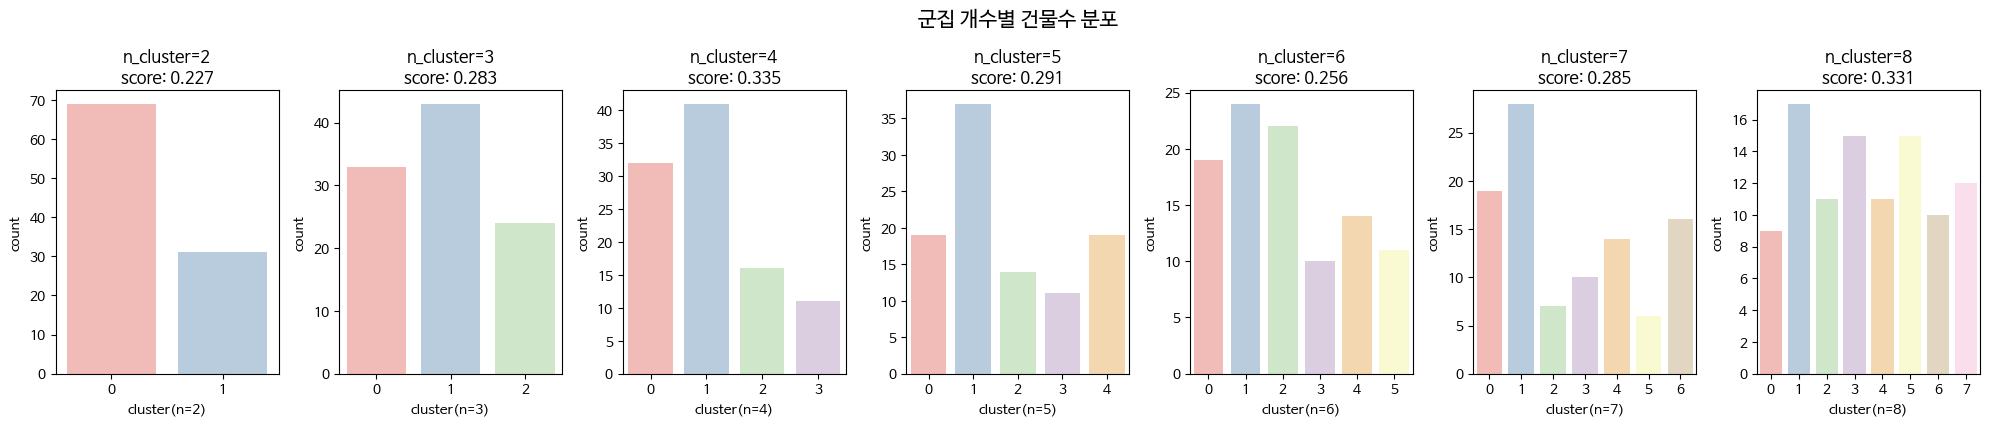

In [223]:
visualize_n_cluster(train_ts, n_lists=range(2,9), metric='euclidean', seed=42, vis=True)

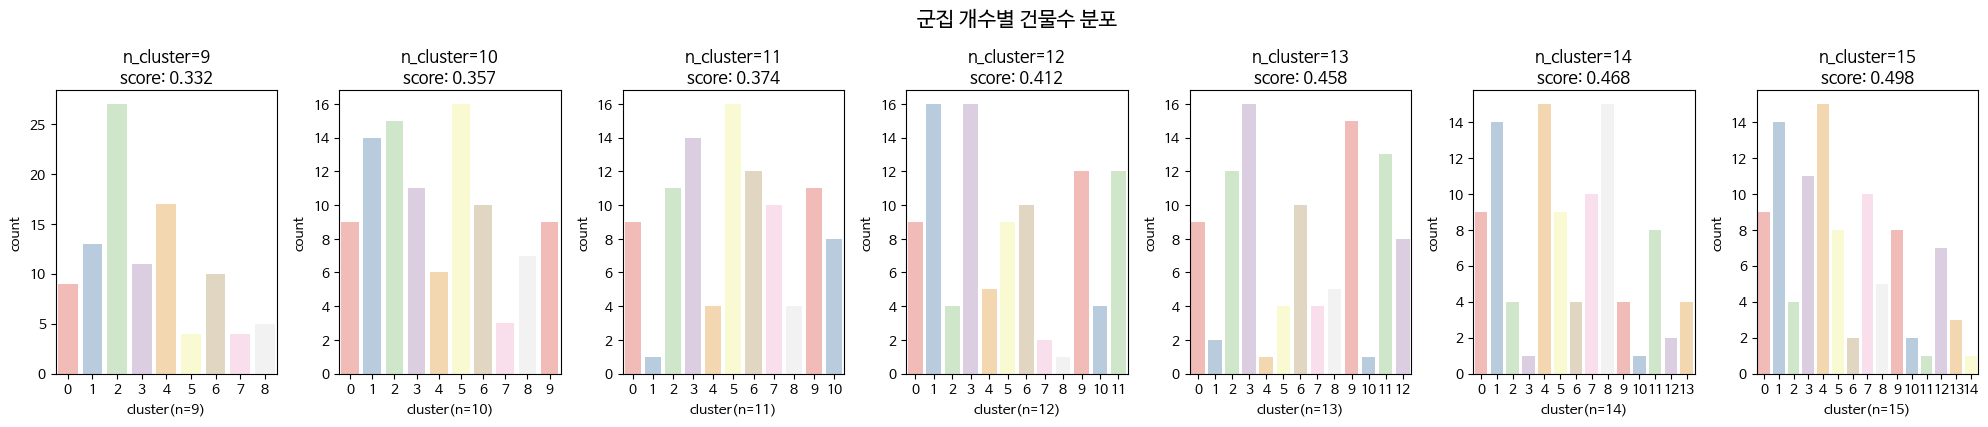

In [224]:
visualize_n_cluster(train_ts, n_lists=range(9,16), metric='euclidean', seed=42, vis=True)

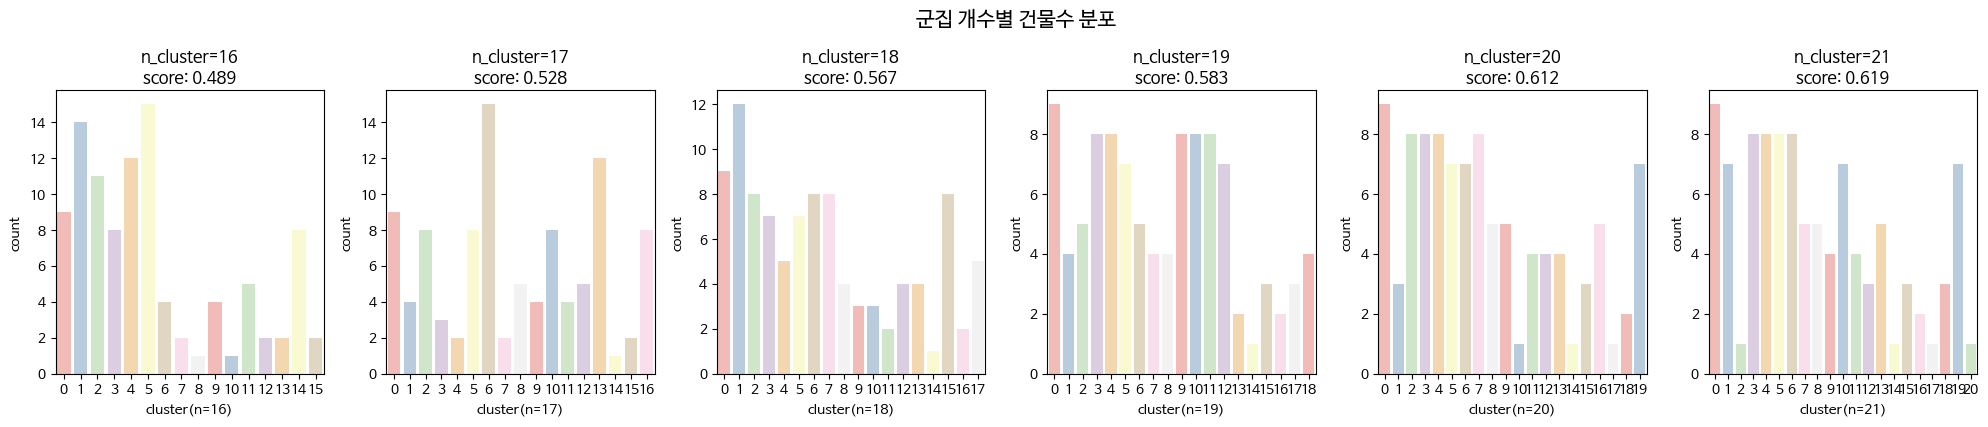

In [225]:
visualize_n_cluster(train_ts, n_lists=range(16,22), metric='euclidean', seed=42, vis=True)

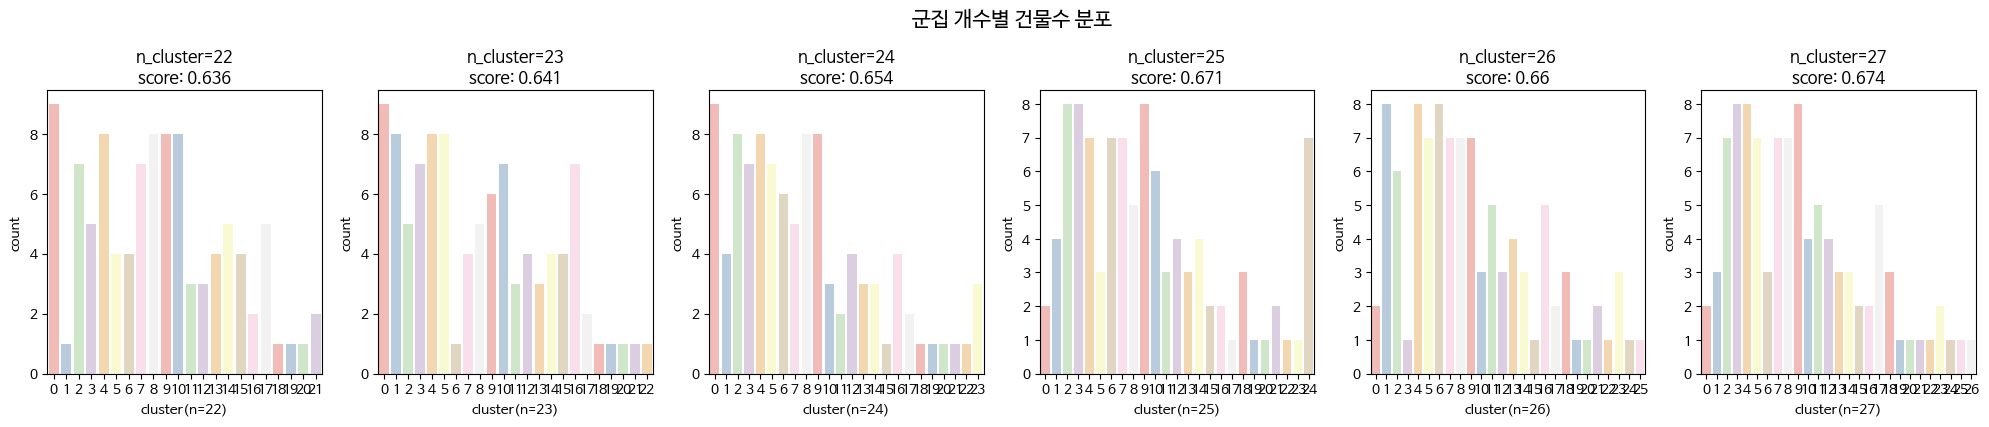

In [226]:
visualize_n_cluster(train_ts, n_lists=range(22,28), metric='euclidean', seed=42, vis=True)

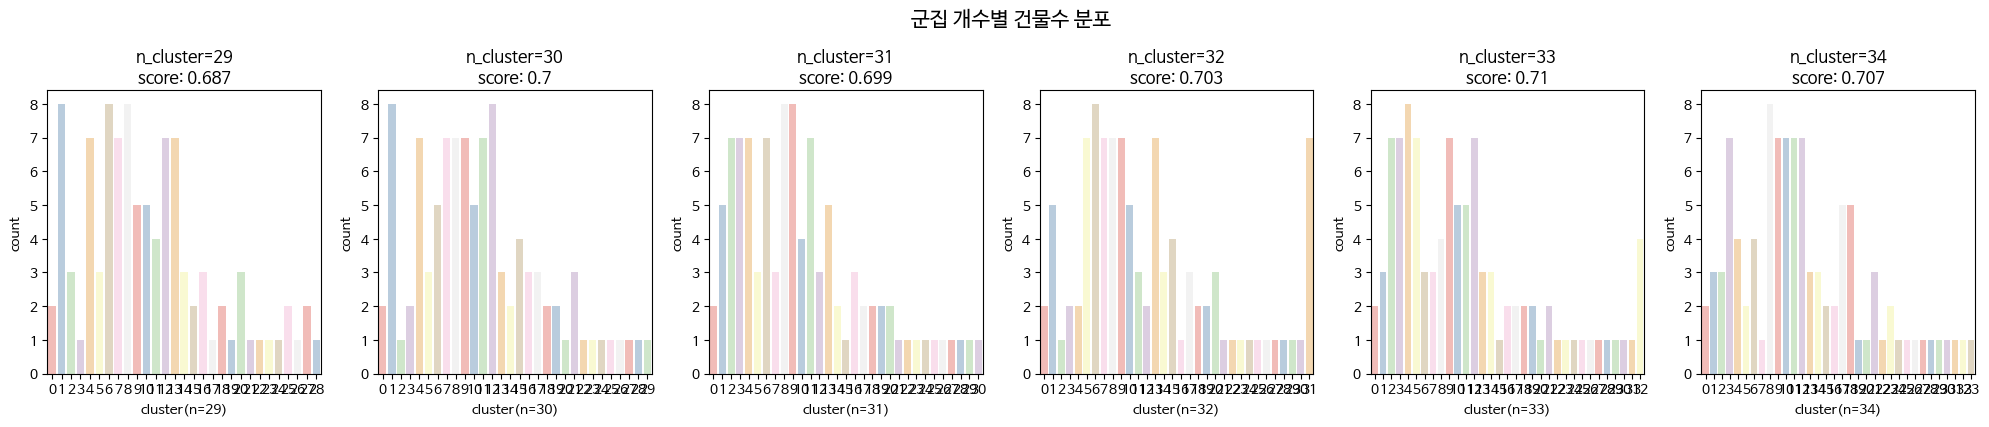

In [227]:
visualize_n_cluster(train_ts, n_lists=range(29,35), metric='euclidean', seed=42, vis=True)

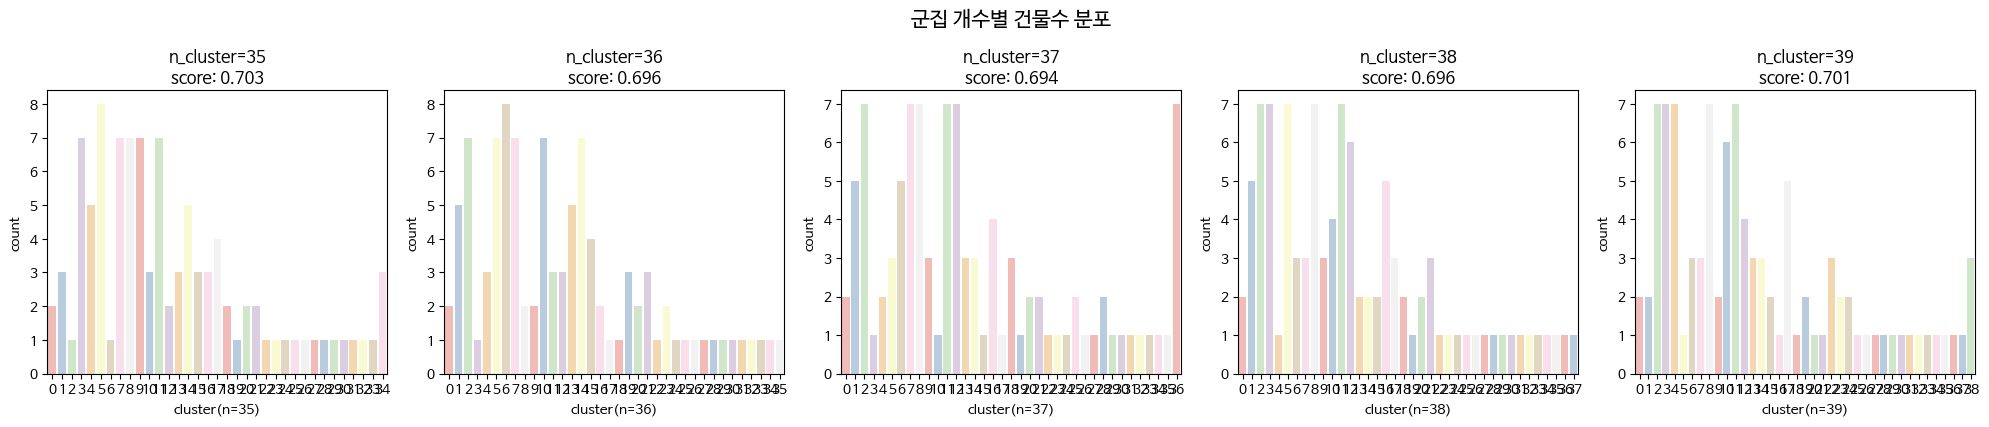

In [228]:
visualize_n_cluster(train_ts, n_lists=range(35,40), metric='euclidean', seed=42, vis=True)

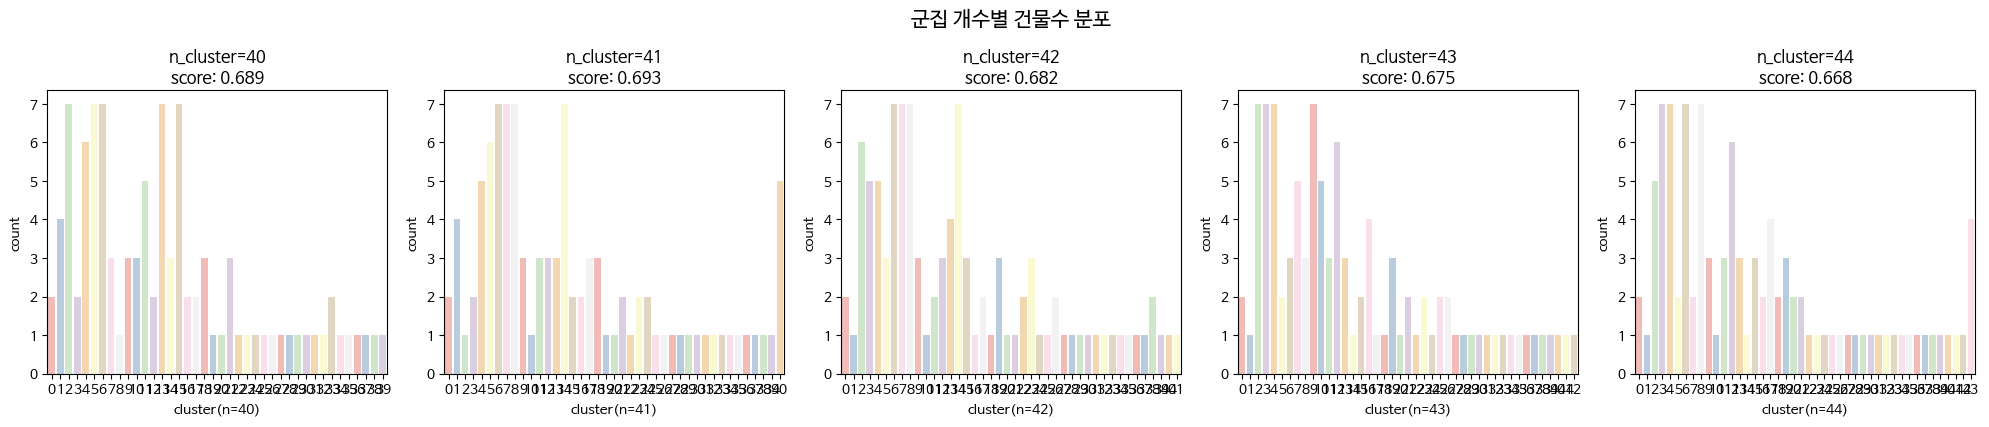

In [229]:
visualize_n_cluster(train_ts, n_lists=range(40,45), metric='euclidean', seed=42, vis=True)

In [230]:
# 클러스터 별 시간&요일별 전력사용량 평균 시각화
def visualize_by_cluster(df_with_labels, n_cluster):
    fig = plt.figure(figsize = (20 ,4*n_cluster))
    plt.title('군집 수가 {}개일 때 각 군집별 시계열분포'.format(n_cluster), fontsize=15, y=1.05)
    plt.axis('off')


    labels = df_with_labels['cluster(n={})'.format(n_cluster)]

    idx=1
    for label in set(labels): # 각 군집에 대해

        df = train[train.build_num.isin(list(labels[labels==label].keys()))]

        time = df.time.unique()
        weekday = df.weekday.unique()

        ### x축: 시간 ###
        ax = fig.add_subplot(n_cluster,2, idx); idx+=1
        ax.set(title='{}번 군집의 시간별 평균 전력사용량'.format(label))
        ax.set_xticks(time)
        for num in df.build_num.unique():
            df_one = df[df.build_num==num]
            sns.lineplot(x=time, y=df_one.groupby('time')['power_consum'].mean(), color='grey', alpha=0.3)
        sns.lineplot(x=time, y=df.groupby('time')['power_consum'].mean(), color='red')

        ### x축: 요일 ###
        ax = fig.add_subplot(n_cluster,2, idx); idx+=1
        ax.set(title='{}번 군집의 요일별 평균 전력사용량'.format(label))
        for num in df.build_num.unique():
            df_one = df[df.build_num==num]
            df_one_counts = df_one.groupby('weekday')['power_consum'].mean()
            df_one_counts = df_one_counts.reindex(weekday)
            sns.lineplot(x=weekday, y=df_one_counts, color='grey', alpha=0.3)
        df_counts = df.groupby('weekday')['power_consum'].mean()
        df_counts = df_counts.reindex(weekday)
        sns.pointplot(x=weekday, y=df_counts, color='red')
        ax.legend(['총 {}개 건물'.format(df.build_num.nunique())], loc=1)

    plt.show()

In [231]:
 # 각 군집별 시계열 분포 시각화
visualize_by_cluster(train_ts, n_cluster = 32)

Output hidden; open in https://colab.research.google.com to view.

In [232]:
# 시계열 군집화용 데이터프레임 생성
info_dummy['cluster_num'] = train_ts['cluster(n=32)'].values

In [233]:
train = train.drop(columns=['time'])
test = test.drop(columns=['time'])

### **병합 및 분리**

In [234]:
# info_dummy 병합
train = pd.merge(train, info_dummy, how='outer', on='build_num')
test = pd.merge(test, info_dummy, how='outer', on='build_num')

In [235]:
# target을 맨 뒤로 (오류 방지를 위해 test와 맞춰주기)
train = train[[col for col in train.columns if col != 'power_consum'] + ['power_consum']]

In [236]:
# 전체 데이터 copy
all = train

In [237]:
# 점수 확인을 위한 train, valid 분리
valid = train[(train['month']==8) & (train['day']>17)]

train = train.drop(valid.index)

In [238]:
# x, y로 분리
train_x = train.drop(columns=['num_date_time', 'date_time', 'power_consum'])
train_y = train['power_consum']

valid_x = valid.drop(columns=['num_date_time', 'date_time', 'power_consum'])
valid_y = valid['power_consum']

test_x = test.drop(columns=['num_date_time', 'date_time'])

all_x = all.drop(columns=['num_date_time', 'date_time', 'power_consum'])
all_y = all['power_consum']

## **4. Modeling**

### **Model Fit & Predict**

In [239]:
# 지정한 컬럼을 기준으로 나눠서 모델 학습 - 전체 데이터로 다시 fitting
def predicting_model(train_data, test_data, model, col_name):
    model_list = {}
    preds_df = pd.DataFrame()
    col_list = train[col_name].unique()

    for col in col_list:
        train_col = train_data[train_data[col_name] == col]
        train_x = train_col.drop(columns=['num_date_time', 'date_time', col_name, 'power_consum'])
        train_y = train_col['power_consum']

        test_col = test_data[test_data[col_name] == col]
        test_x = test_col.drop(columns=['num_date_time', 'date_time', col_name])

        model.fit(train_x, train_y)
        model_list[col] = model

        test_col['preds'] = model.predict(test_x)
        preds_df = pd.concat([preds_df, test_col[['build_num', 'date_time', 'preds']]])

    preds_df = preds_df.sort_values(by=['build_num', 'date_time'], ascending=[True, True])

    return preds_df['preds'].values, model_list

In [240]:
model = XGBRegressor(max_depth=9,
                     learning_rate=0.00766266279800814,
                     n_estimators=1000,
                     min_child_weight=1.3856172663698525,
                     subsample=0.33075937051498133,
                     colsample_bytree=0.49643382704422895,
                     seed=42)

In [241]:
model.set_params(**{'objective':'reg:squarederror', 'alpha': 0.002778691788301835, 'lambda': 6.005227238760956})

XGBRegressor(alpha=0.002778691788301835, base_score=None, booster=None,
             callbacks=None, colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.49643382704422895, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             lambda=6.005227238760956, learning_rate=0.00766266279800814,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=9, max_leaves=None,
             min_child_weight=1.3856172663698525, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1000,
             n_jobs=None, ...)

In [242]:
preds, model_list = predicting_model(all, test, model, 'cluster_num')

## **5. Submission**

In [243]:
submission = pd.read_csv('./data/sample_submission.csv')
submission

,num_date_time,answer
0,1_20220825 00,0
1,1_20220825 01,0
2,1_20220825 02,0
3,1_20220825 03,0
4,1_20220825 04,0
...,...,...
16795,100_20220831 19,0
16796,100_20220831 20,0
16797,100_20220831 21,0
16798,100_20220831 22,0


In [244]:
submission['answer'] = preds
submission

,num_date_time,answer
0,1_20220825 00,2066.029053
1,1_20220825 01,1967.138306
2,1_20220825 02,1853.236694
3,1_20220825 03,1747.873169
4,1_20220825 04,1752.604248
...,...,...
16795,100_20220831 19,958.347534
16796,100_20220831 20,829.533081
16797,100_20220831 21,769.320984
16798,100_20220831 22,669.983582


In [ ]:
submission.to_csv('./submission/final_submission.csv', index=False)